# Дисперсионный анализ для повторяющихся наблюдений


In [ ]:
df <- read.csv("/content/data_ARM.csv")
df <- na.omit(df)
head(df)

,X,PRCOD.1,SEX.1,SSTATA.1,SSTATA.2,SSTATA.3
,<int>,<chr>,<chr>,<int>,<int>,<dbl>
2,2,Placebo+Framex,male,39,43,40
3,3,NLTX+Framex,female,48,51,48
4,4,Placebo+Framex,male,51,50,42
5,5,NLTX+Placebo,male,21,23,22
6,6,NLTX+Framex,female,54,30,35
7,7,NLTX+Framex,male,35,23,26


Выделим подгруппу с типом лечения `Placebo+Framex`.

In [ ]:
df <- df[df[, "PRCOD.1"] == "Placebo+Framex",]
head(df)

,X,PRCOD.1,SEX.1,SSTATA.1,SSTATA.2,SSTATA.3
,<int>,<chr>,<chr>,<int>,<int>,<dbl>
2,2,Placebo+Framex,male,39,43,40
4,4,Placebo+Framex,male,51,50,42
8,8,Placebo+Framex,male,32,46,31
13,13,Placebo+Framex,female,43,37,41
16,16,Placebo+Framex,male,65,56,52
25,25,Placebo+Framex,male,58,23,21


Узнаем количество индивидов разных полов.

In [ ]:
length(which(df$SEX.1 == "female"))
length(which(df$SEX.1 == "male"))

[1] 8

[1] 26

Объединим различные измерения SSTATA в одну переменную.

In [ ]:
df_new <- data.frame(stack(df[, 4:6]),
              X = as.factor(rep(df$X, 3)),
              SEX = as.factor(rep(df$SEX.1, 3)))
head(df_new)

,values,ind,X,SEX
,<dbl>,<fct>,<fct>,<fct>
1,39,SSTATA.1,2,male
2,51,SSTATA.1,4,male
3,32,SSTATA.1,8,male
4,43,SSTATA.1,13,female
5,65,SSTATA.1,16,male
6,58,SSTATA.1,25,male


Для дальнейших вычислений посчитаем средние (общее и по различным группам).

In [ ]:
mean_all <- mean(df_new$values) # общее
mean_sex <- tapply(X = df_new$values, INDEX = df_new$SEX, FUN = mean) # по полу
mean_ind <- tapply(X = df_new$values, INDEX = df_new$ind, FUN = mean) # по номеру измерения
mean_sex_ind <- tapply(X = df_new$values, INDEX = list(df_new$SEX, df_new$ind), FUN = mean) # по полу и номеру
mean_person <- tapply(X = df_new$values, INDEX = df_new$X, FUN = mean) # по индивиду

### Источники вариации

Выделим номера мужчин и женщин и средние

In [ ]:
women_pos <- df_new$SEX == "female"
women <- mean_person[women_pos]
men <- mean_person[!women_pos]
# df_new[!women_pos, ]
women

13       44      117      177      189      192      213      276 
40.33333 47.66667 32.66667 41.00000 40.66667 42.33333 55.66667 40.33333 
    <NA>     <NA>     <NA>     <NA>     <NA>     <NA>     <NA>     <NA> 
      NA       NA       NA       NA       NA       NA       NA       NA 
    <NA>     <NA>     <NA>     <NA>     <NA>     <NA>     <NA>     <NA> 
      NA       NA       NA       NA       NA       NA       NA       NA

In [ ]:
Q <- (df_new$values - mean_all) %*% (df_new$values - mean_all) # общий
Q_A <- 3 * (length(which(df$SEX.1 == "female")) * ((mean_sex[1] - mean_all)^2) + length(which(df$SEX.1 == "male")) * ((mean_sex[2] - mean_all)^2))
Q_1e <- 3 * ((women[!is.na(women)] - mean_sex[1]) %*% (women[!is.na(women)] - mean_sex[1]) + (men[!is.na(men)] - mean_sex[2]) %*% (men[!is.na(men)] - mean_sex[2]))
Q_1 <- Q_A + Q_1e
Q_C <- length(df$X) * (mean_ind - mean_all) %*% (mean_ind - mean_all)
Q_AC <- length(which(df$SEX.1 == "female")) * (mean_sex_ind[1,] - mean_sex[1] - mean_ind + mean_all) %*% (mean_sex_ind[1,] - mean_sex[1] - mean_ind + mean_all) + length(which(df$SEX.1 == "male")) * (mean_sex_ind[2,] - mean_sex[2] - mean_ind + mean_all) %*% (mean_sex_ind[2,] - mean_sex[2] - mean_ind + mean_all)
Q_2 <- Q - Q_1
Q_err <- Q_2 - Q_C - Q_AC

Степени свободы

In [ ]:
nu_1 <- length(df$X) - 1 # n-1
nu_A <- 2-1 # число различных полов - 1
nu_1e <- length(df$X) - 2 # n - значений фактора пола
nu_C <- 3 - 1 # число измерений во времени - 1
nu_AC <- (3 - 1) * (2 - 1)
nu_err <- (3 - 1) * (length(df$X) - 2)

### Проверка гипотезы, что все дифференциальные эффекты фактора пола равны нулю

In [ ]:
MQ_A <- Q_A / nu_A
MQ_1e <- Q_1e / nu_1e
F_A <- MQ_A / MQ_1e
print("Статистика для фактора пола:")
F_A
print("p-value:")
1-pf(F_A, nu_A, nu_1e)

[1] "Статистика для фактора пола:"


0.2976109


[1] "p-value:"


0.589167


Влияние фактора пола не значимо.

### Проверка гипотезы, что случайные эффекты фактора времени имеют нулевую дисперсию

In [ ]:
MQ_C <- Q_C / nu_C
MQ_AC <- Q_AC / nu_AC
F_C_r <- MQ_C / MQ_AC
print("Статистика для фактора времени:")
F_C_r
print("p-value:")
1-pf(F_C_r, nu_C, nu_AC)

[1] "Статистика для фактора времени:"


1.076847


[1] "p-value:"


0.4814992


Случайные эффекты фактора времени не значимы.

### Проверка гипотезы о фиксированных эффектах фактора времени

In [ ]:
MQ_err <- Q_err / nu_err
F_C_f <- MQ_C / MQ_err
print("Статистика для фактора времени:")
F_C_f
print("p-value:")
1-pf(F_C_f, nu_C, nu_err)

[1] "Статистика для фактора времени:"


5.419788


[1] "p-value:"


0.006692016


Фиксированные эффекты фактора времени значимы.

### Проверка эффекта взаимодействия

In [ ]:
F_int <- MQ_AC / MQ_err
print("Статистика для эффекта взаимодействия:")
F_int
print("p-value:")
1-pf(F_int, nu_AC, nu_err)

[1] "Статистика для эффекта взаимодействия:"


5.033017


[1] "p-value:"


0.009331431


Влияние фактора взаимодействия значимо.

Построим график.

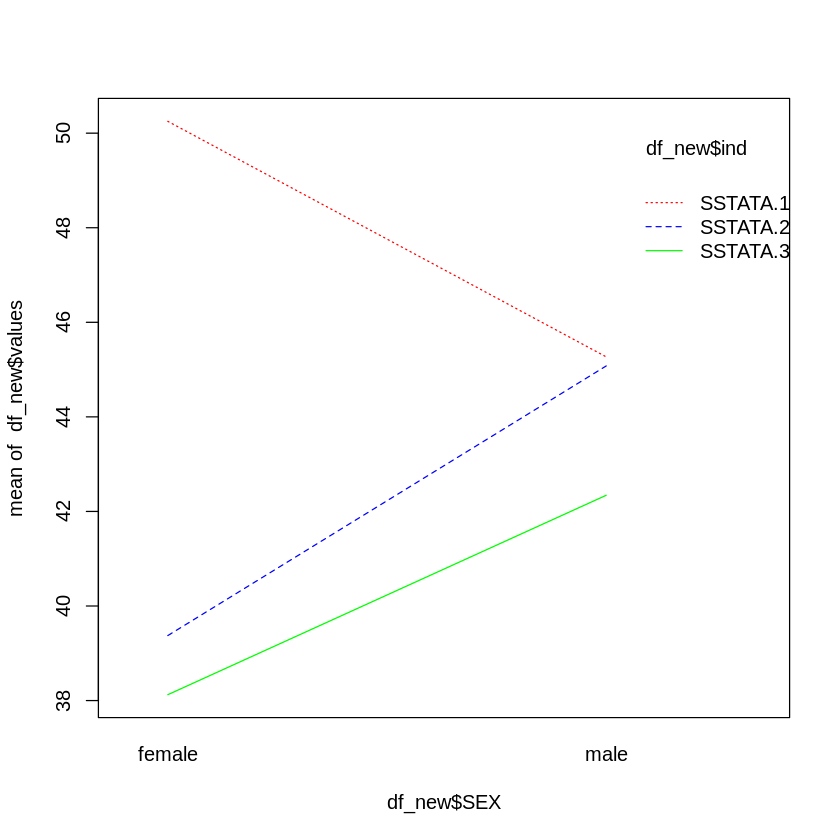

In [ ]:
interaction.plot(df_new$SEX, df_new$ind, df_new$values, col = c("red", "blue", "green"))

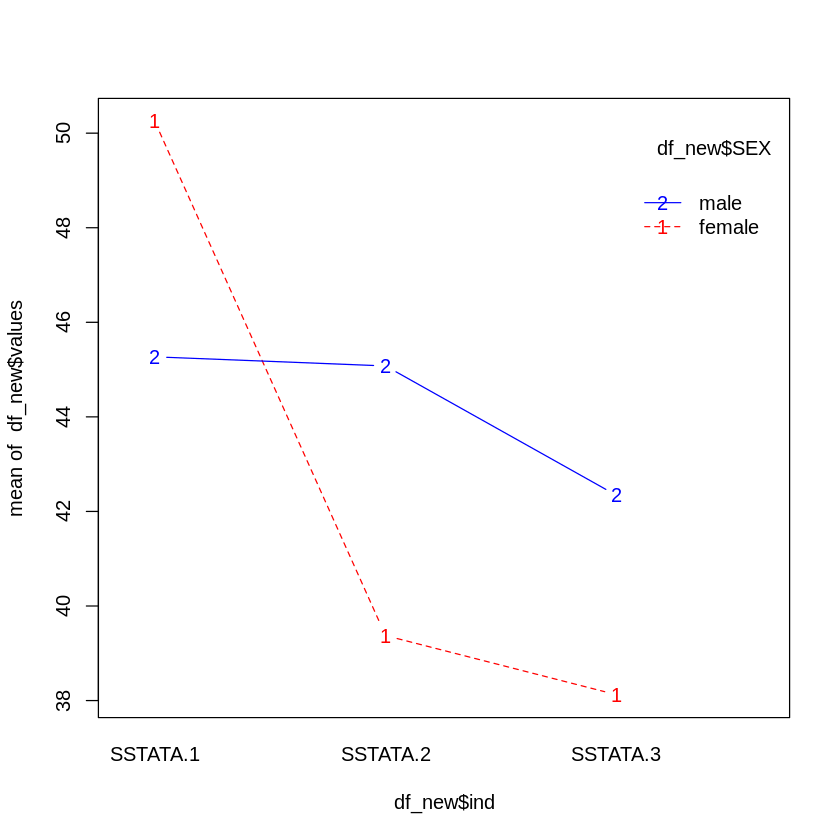

In [ ]:
interaction.plot(x.factor = df_new$ind, trace.factor = df_new$SEX,
                 response = df_new$values, fun = mean,
                 type = "b", legend = TRUE, col = c("red", "blue"))

### Стандартная процедура для контроля вычислений

In [ ]:
aov_mod <- aov(values ~ SEX * ind, data=df_new)
summary(aov_mod)

            Df Sum Sq Mean Sq F value Pr(>F)  
SEX          1     50   49.73   0.600 0.4403  
ind          2    441  220.61   2.663 0.0749 .
SEX:ind      2    410  204.87   2.473 0.0897 .
Residuals   96   7953   82.84                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1